# Simulating PM$_{2.5}$ Concentrations using Smoke3d

<hr style="border-width:4px; border-color:coral"></hr> 

This notebook simulates PM$_{2.5}$ concentrations in California using the Smoke3d solver implemented in [ForestClaw](https://github.com/ForestClaw/ForestClaw/wiki), a suite for solving hyperbolic PDEs. Smoke3d is a data-enabled model which solves for the 3-D transport of smoke using accurate and conservative numerical schemes. Smoke3d is computationally cost-effective because it uses adaptive mesh refinement (from ForestClaw) to target only regions with smoke on large domains.

In [1]:
%matplotlib notebook

from numpy import *
import numpy.linalg 
from matplotlib.pyplot import *

### Importing Modules that help us mimic the functionality of the Unix shell

<hr style="border-width:4px; border-color:coral"></hr> 

Before running this notebook, we assume that the user already has ForestClaw and Smoke3d installed.

To be able to run ForestClaw in Python, we imported the "subprocess", "shlex", and "os" modules. With these modules, we can call shell commands as though on the terminal. They also enable us to connect to input files and return the outputs of their codes.

In [2]:
import subprocess
import shlex
import os

## Problem Setup for Source Terms

<hr style="border-width:4px; border-color:coral"></hr> 

Like in all smoke modeling scenarios, we need a model that describes smoke production and transport. We describe this process with a transport equation:

\begin{equation}
		\mathbf{q_t}(\mathbf{x}, t) + \nabla\cdot \mathbf u(\mathbf{x}, t)\mathbf{q}(\mathbf{x}, t) = \mathbf S(\mathbf{x}, t),
\end{equation}

where:
	
$\mathbf{q}(\mathbf{x}, t)$: PM$_{2.5}$ concentrations measured in $\mu\text{gm$^{-3}$}$ at the geographical location, $\mathbf x$, and time, $t$

$\mathbf u(\mathbf{x}, t)$: wind field (velocity)

$S(\mathbf{x}, t)$: source term measured in $\mu\text{gm$^{-3}$ s$^{-1}$}$ 
	
The initial condition is:
\begin{equation}
	\mathbf{q}(\mathbf{x}, 0) = q^0(\mathbf{x}).
\end{equation}
	
$q^0(\mathbf{x})$ is the initial concentration of smoke, which we assume to be zero.


A prescribed velocity field $(u_1, u_2)$ in degrees/second is given below:

\begin{equation}
u_1 = v_1 \left(\cos\left(\frac{64\pi y_{lat}}{180}\right) + \left(\frac{x_{long} - x_0}{100}\right)\right)\\
u_2 = v_2.
\end{equation}
The scaling factors $(v_1, v_2)$, computed on latitude 42$^{\circ}\text{N}$ is 0.00002 degrees/second, which corresponds to a wind speed of 20 $\text{m/s}$.

**Note:** This velocity field was set up for demonstration purposes, and other than the scaling factor, it is not meant to be physical.

We assume the fire to be a circular disk in such a way that for the constant source term, because the radius from the centre of the disk to any point in the disk is equal, the value of the source term within the disk is the initial, $S_0$, and outside the disk, it is zero. On the other hand, for the Gaussian source term, the value of the source term within the disk is $S_0$ multiplied by an exponential term, and outside the disk, it is zero. The two functions are defined below:

**Constant Source Term**

\begin{equation}
\mathbf S(\mathbf x, t) = S(r) = \begin{cases}
S_0, & \text{if r $\leq$ R}\\
0, & \text{otherwise}
\end{cases}
\end{equation}
where $r^2 = (x-x_0)^2+(y-y_0)^2$, and $R$ is the radius of the fire.

**Gaussian Source Term**

\begin{equation}
\mathbf S(\mathbf x, t) = S(r) = \begin{cases}
S_0\exp\left(-\alpha r^2\right), & \text{if r $\leq$ R}\\
0, & \text{otherwise}
\end{cases}
\end{equation}

$\alpha$ is the parameter which determines how sharp the Gaussian is. 


We present the plots of the two source terms below.

<IPython.core.display.Javascript object>


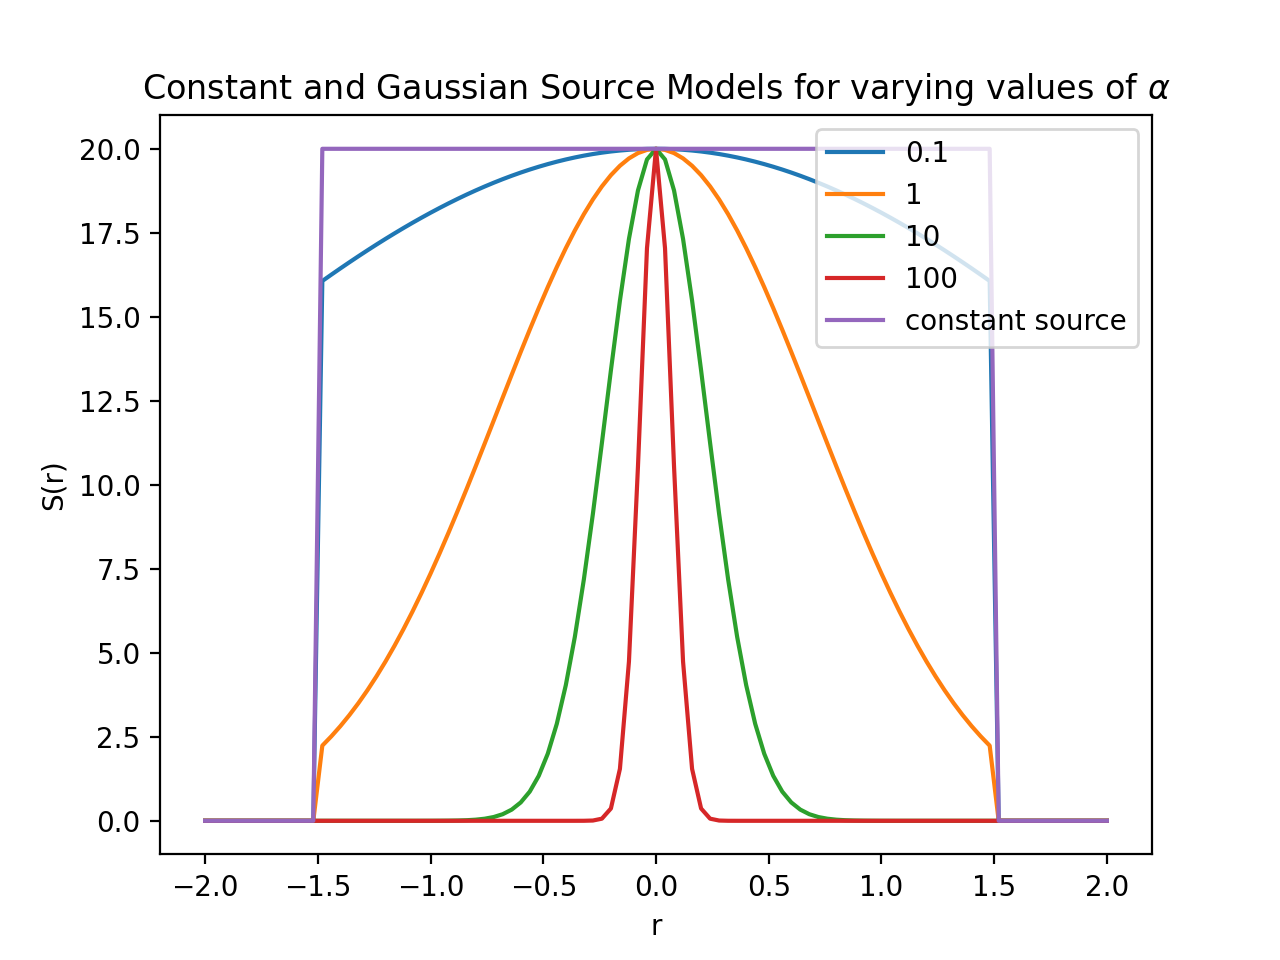

In [7]:
r = linspace(-2,2,101)
R = 1.5
alpha = [1e-1,1,10,100]
S_0 = 20

figure(1)
clf

CS = where(abs(r) < R, S_0, 0)

for i in range(len(alpha)):
    GS = CS*exp(-alpha[i]*r**2)
    plot(r,GS, label=alpha[i])
plot(r,CS,label='constant source') 
xlabel('r')
ylabel('S(r)')
title(r'Constant and Gaussian Source Models for varying values of $\alpha$')
legend(loc='upper right')  
show()





## ForestClaw Wrapper

<hr style="border-width:4px; border-color:coral"></hr> 

We proceed to wrap ForestClaw in a Python function in such a way that it reads data from a ForestClaw options file, `fclaw_options.ini`. This file contains the following data:

* spatial resolution of the location being considered, in this case, California.

* velocity, radius (Earth and fire radius), source model

* time-step and final time, grid dimensions, regridding options, etc


The wrapper takes in the input parameters that control the source term, that is $S_0$ for the constant source model, and $S_0$ and $\alpha$ for the Gaussian source model.  

In [4]:
alpha = 0.1

# Keep track of how many times we call ForestClaw
fclaw_counter = 0

def run_ForestClaw(S,alpha=alpha):
    # Parameters : 
    global fclaw_counter
    shell_cmd = './latlong --user:source-model={:d} --user:S0={:.16f} --user:alpha={:.16e}'.format
    cmd = shell_cmd(source_model, S,alpha)
    arg_list = shlex.split(cmd) 
    output = subprocess.run(arg_list, capture_output=True,text=True) 
    
    fclaw_counter += 1
    return output.returncode, output

## Constant Source Term

<hr style="border-width:4px; border-color:coral"></hr> 

Here, we define a value of our choice for the constant source term.

In [5]:
source_model = 1  #constant source term
S_true = 20

errout,output = run_ForestClaw(S_true)

if errout != 0:
    print("latlong : Something bad happened!")
    print(output.stdout)
    exit(0)
else:
    print("Test successful!")        
    
# Reset counter
fclaw_counter = 0


Test successful!


## Gaussian Source Term

<hr style="border-width:4px; border-color:coral"></hr> 

Just like we did in the constant source term, we specify the source model and define values for $S_0$ and $\alpha$.

In [6]:
source_model = 2 # gaussian source term

S_true = 20
alpha_true = alpha


errout,output = run_ForestClaw(S_true,alpha_true)

if errout != 0:
    print("latlong : Something bad happened!")
    print(output.stdout)
    exit(0)
else:
    print("Test successful!")        
    
# Reset counter
fclaw_counter = 0
    

Test successful!


## Example
<hr style="border-width:4px; border-color:coral"></hr> 

Below, we present the plot of PM$_{2.5}$ concentrations using the constant and Guassian source models. The plots were obtained using the Clawpack-Visclaw package in MATLAB.


![alt text](model.png)

